$$\textbf{u}=-\frac{\textbf{k}}{\mu}(\nabla p - \rho g)$$

$$\phi \frac{\partial p}{\partial t} - \frac{1}{\mu} \nabla \cdot (\textbf{k} \nabla p) = q$$




In [48]:
from mpi4py import MPI
from dolfinx import mesh
import ufl
import numpy as np
from dolfinx import fem

class BoundaryCondition():
    def __init__(self, type, marker, values,facet_tag, functionspace,fdim,ds=None):
        self._type = type
        if type == "Dirichlet":
            if callable(values):
                u_D = fem.Function(functionspace)
                u_D.interpolate(values)
                facets = facet_tag.find(marker)
                dofs = fem.locate_dofs_topological(functionspace, fdim, facets)
                self._bc = fem.dirichletbc(u_D, dofs)
            else:
                facets = facet_tag.find(marker)
                dofs = fem.locate_dofs_topological(functionspace, fdim, facets)
                self._bc = fem.dirichletbc(values, dofs,functionspace) #wall_dofs, V)
        elif type == "Neumann":
                self._bc = ufl.inner(values, v) * ds(marker)
        elif type == "Robin":
            self._bc = values[0] * ufl.inner(u-values[1], v)* ds(marker)
        else:
            raise TypeError("Unknown boundary condition: {0:s}".format(type))
    @property
    def bc(self):
        return self._bc

    @property
    def type(self):
        return self._type
    



In [49]:
import numpy as np
from dolfinx import fem
from dolfinx import mesh
import ufl
from mpi4py import MPI
from petsc4py import PETSc

from basix.ufl import element



In [68]:
domain = mesh.create_unit_square(MPI.COMM_WORLD, 10, 10)

tdim = domain.topology.dim
fdim = tdim - 1
domain.topology.create_connectivity(fdim, tdim)

x = ufl.SpatialCoordinate(domain)

t = 0
T = 1
num_steps = 10000

dt = T / num_steps

def K(x):
    #return 1.0/(ufl.exp(-(((x[1] - 0.5 - 0.1*ufl.sin(10*x[0]))/0.1)*((x[1] - 0.5 - 0.1*ufl.sin(10*x[0]))/0.1))) + 1.0)
    return 1*ufl.exp(-1*((x[0]-0.5)**2+(x[1]-0.5)**2)/0.0001)
    #return 0.1

n = ufl.FacetNormal(domain)
q = fem.Constant(domain, PETSc.ScalarType(0))
dt_ = fem.Constant(domain, PETSc.ScalarType(dt))
mu = fem.Constant(domain, PETSc.ScalarType(0.3))
phi = fem.Constant(domain, PETSc.ScalarType(0.5))

#Elements
s_cg1 = element("Lagrange", domain.topology.cell_name(), 1)
P = fem.functionspace(domain, s_cg1)

p = ufl.TrialFunction(P)
v = ufl.TestFunction(P)

#Boundaries
boundaries=[
    (1, lambda x: np.isclose(x[0],0)), # x=0
    (2, lambda x: np.isclose(x[0],1)), # x=1
    (3, lambda x: np.isclose(x[1],0)), # y=0
    (4, lambda x: np.isclose(x[1],1)) # y=1
]

facet_indices,facet_markers=[],[]
for (marker, locator) in boundaries:
    facets= mesh.locate_entities(domain,fdim,locator)
    facet_indices.append(facets)
    facet_markers.append(np.full_like(facets,marker))
facet_indices=np.hstack(facet_indices).astype(np.int32)
facet_markers=np.hstack(facet_markers).astype(np.int32)
sorted_facets=np.argsort(facet_indices)
facet_tag=mesh.meshtags(domain,fdim,facet_indices[sorted_facets],facet_markers[sorted_facets])


#x_ufl = 1 + x[0] + 2 * x[1]

#h = - ufl.div(K(x_ufl) * ufl.grad(x_ufl))


#pressure_boundary_conditions=[
#    BoundaryCondition("Dirichlet", 1, PETSc.ScalarType(0.0),facet_tag,P,fdim)._bc,
#    BoundaryCondition("Dirichlet", 2, PETSc.ScalarType(0.0),facet_tag,P,fdim)._bc,
#    BoundaryCondition("Dirichlet", 3, PETSc.ScalarType(0.1),facet_tag,P,fdim)._bc,
#    BoundaryCondition("Dirichlet", 4, PETSc.ScalarType(0.7),facet_tag,P,fdim)._bc
#                      ]

pressure_boundary_conditions=[
    BoundaryCondition("Dirichlet", 1, (lambda x: 1-x[0]),facet_tag,P,fdim)._bc,
    BoundaryCondition("Dirichlet", 2, (lambda x: 1-x[0]),facet_tag,P,fdim)._bc,
    BoundaryCondition("Dirichlet", 3, (lambda x: 1-x[0]),facet_tag,P,fdim)._bc,
    BoundaryCondition("Dirichlet", 4, (lambda x: 1-x[0]),facet_tag,P,fdim)._bc
                      ]

## Discretization in time

$$\frac{\partial p}{\partial t} \approx \left ( \frac{p^{n+1}-p^{n}}{\Delta t} \right )$$

$$\left ( \frac{p^{n+1}-p^{n}}{\Delta t} \right ) = q + \frac{1}{\phi\mu} \nabla \cdot (\textbf{k} \nabla p)$$

$$ p^{n+1} = p^{n} + \Delta t \left ( q + \frac{1}{\phi\mu} \nabla \cdot (\textbf{k} \nabla p) \right )$$

## For Prediction Correction scheme

### Predictor:

$$\left ( \frac{p^{*}-p^{n}}{\Delta t} \right ) = q + \frac{1}{\phi\mu} \nabla \cdot (\textbf{k} \nabla p^n)$$
$$ p^{*} = p^{n} + \Delta t \left ( q^n + \frac{1}{\phi\mu} \nabla \cdot (\textbf{k} \nabla p^n) \right )$$

#### Solve for $p^*$, apply inner product:

$$\left \langle \frac{p^{*}-p^{n}}{\Delta t} ,v \right \rangle_{\Omega} = \langle q,v \rangle_{\Omega} + \left \langle \frac{1}{\phi\mu} \nabla \cdot (\textbf{k} \nabla p^n) \right \rangle_{\Omega} $$

#### Solve for $p^{n+1}$, apply inner product:

### Corrector

$$\left ( \frac{p^{n+1}-p^{n}}{\Delta t} \right ) =\frac{1}{2} \left [
    (q^{n} + \frac{1}{\phi\mu} \nabla \cdot (\textbf{k} \nabla p^{n})bla \cdot (\textbf{k} \nabla p^{*})) 
    \right ]$$

$$ p^{n+1} = p^{n} + \frac{\Delta t}{2} \left [
    (q^{n} + \frac{1}{\phi\mu} \nabla \cdot (\textbf{k} \nabla p^{n})) +
    (q^{n+1} + \frac{1}{\phi\mu} \nabla \cdot (\textbf{k} \nabla p^{*})) 
    \right ]$$

#### Solve for $p^{n+1}$, apply inner product:

$$\left \langle \frac{2(p^{n+1}-p^{n})}{\Delta t} , v \right \rangle_{\Omega}  = 
\left \langle
    \left ( q^{n} + \frac{1}{\phi\mu} \nabla \cdot (\textbf{k} \nabla p^{n}) \right ) +
    \left ( q^{n+1} + \frac{1}{\phi\mu} \nabla \cdot (\textbf{k} \nabla p^{*}) \right ) 
    , v \right \rangle_{\Omega} 
    $$

## Basic euler time discretization

$$\left ( \frac{p^{n+1}-p^{n}}{\Delta t} \right ) = q + \frac{1}{\phi\mu} \nabla \cdot (\textbf{k} \nabla p)$$

$$\left ( p^{n+1}-p^{n} \right ) = \Delta t q + \frac{\Delta t}{\phi\mu} \nabla \cdot (\textbf{k} \nabla p)$$

#### Solve for $p^{n+1}$, apply inner product:

$$\left \langle \frac{p^{n+1}-p^{n}}{\Delta t} , v \right \rangle_{\Omega} = \left \langle q + \frac{1}{\phi\mu} \nabla \cdot (\textbf{k} \nabla p) , v \right \rangle_{\Omega} $$


$$
\left \langle \left ( p^{n+1}-p^{n} \right ) , v \right \rangle_{\Omega} = 
\Delta t \left \langle  q ,v \right \rangle_{\Omega} + 
\frac{\Delta t}{\phi\mu} \textbf{k}(\textbf{x}) \left \langle \nabla p, \nabla v \right \rangle_{\Omega} -
\Delta t \left \langle \nabla (\textbf{k}(\textbf{x}) \nabla p) , v \right \rangle_{\partial \Omega} 
$$

$$
\left \langle \left ( p^{n+1}-p^{n} \right ) , v \right \rangle_{\Omega} 
- \frac{\Delta t}{\phi\mu} \textbf{k}(\textbf{x}) \left \langle \nabla p, \nabla v \right \rangle_{\Omega}
= \Delta t \left \langle  q ,v \right \rangle_{\Omega} 
 - \Delta t \left \langle (\textbf{k}(\textbf{x}) \nabla p) , v \right \rangle_{\partial \Omega} 
$$

In [69]:
import dolfinx.fem.petsc

def initial_condition(x):
    #return np.array([0.1])
    return np.array([0.1])+x[0]*np.array([0.7])

# Define the variational problem for the first step
p_n = dolfinx.fem.Function(P)
p_n.name = "p_n"
p_n.interpolate(initial_condition)

ph = dolfinx.fem.Function(P)
ph.name = "ph"
ph.interpolate(initial_condition)

F1 = ufl.dot((p - p_n), v) * ufl.dx
F1 -= (dt_ / (phi*mu)) * K(x) * ufl.dot(ufl.grad(p), ufl.grad(v)) * ufl.dx
F1 -= dt_ *ufl.inner(q,v) * ufl.dx
#F1 -= dt_ * ufl.inner(h,v) * ufl.dx
#F1 += ufl.dot(p_n * n, v) * ufl.ds - ufl.dot(mu * ufl.nabla_grad(U) * n, v) * ufl.ds

a1 = fem.form(ufl.lhs(F1))
L1 = fem.form(ufl.rhs(F1))
import dolfinx.fem.petsc
A1 = fem.petsc.assemble_matrix(a1, bcs=pressure_boundary_conditions)
A1.assemble()
b1 = fem.petsc.create_vector(L1)

In [70]:
# Solver for step 1
solver1 = PETSc.KSP().create(domain.comm)
solver1.setOperators(A1)
solver1.setType(PETSc.KSP.Type.BCGS)
pc1 = solver1.getPC()
pc1.setType(PETSc.PC.Type.HYPRE)
pc1.setHYPREType("boomeramg")


In [71]:
from dolfinx.io import VTXWriter
from pathlib import Path
folder = Path("results")
folder.mkdir(exist_ok=True, parents=True)
#vtx_u = VTXWriter(domain.comm, folder / "poiseuille_u.bp", u_n, engine="BP4")
vtx_p = VTXWriter(domain.comm, folder / "darcy_fluid_p.bp", p_n, engine="BP4")
vtx_p.write(t)

In [72]:
def u_exact(x):
    values = np.zeros((2, x.shape[1]), dtype=PETSc.ScalarType)
    values[0] = 4 * x[1] * (1.0 - x[1])
    return values


u_ex = fem.Function(V)
u_ex.interpolate(u_exact)

L2_error = fem.form(ufl.dot(u_ - u_ex, u_ - u_ex) * ufl.dx)

NameError: name 'V' is not defined

In [17]:
! apt install -y libgl1-mesa-glx xvfb
#! pip3 install pyvista


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libgl1-mesa-glx is already the newest version (23.0.4-0ubuntu1~22.04.1).
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.14).
0 upgraded, 0 newly installed, 0 to remove and 57 not upgraded.


In [66]:
import pyvista
from dolfinx import plot
import matplotlib as mpl
pyvista.start_xvfb()

grid = pyvista.UnstructuredGrid(*plot.vtk_mesh(P))

plotter = pyvista.Plotter()
plotter.open_gif("u_time.gif", fps=10)

grid.point_data["ph"] = ph.x.array
#warped = grid.warp_by_scalar("ph", factor=1)

viridis = mpl.colormaps.get_cmap("viridis").resampled(25)
sargs = dict(title_font_size=25, label_font_size=20, fmt="%.2e", color="black",
             position_x=0.1, position_y=0.8, width=0.8, height=0.01)

renderer = plotter.add_mesh(grid, show_edges=True, lighting=False,
                            cmap=viridis, scalar_bar_args=sargs,
                            clim=[0, max(ph.x.array)])

In [ ]:
Pv=[]
Vv=[]
for i in range(num_steps):
    # Update current time step
    t += dt

    # Step 1: Tentative veolcity step
    with b1.localForm() as loc_1:
        loc_1.set(0)
    dolfinx.fem.petsc.assemble_vector(b1, L1)
    dolfinx.fem.petsc.apply_lifting(b1, [a1], [pressure_boundary_conditions])
    b1.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
    dolfinx.fem.petsc.set_bc(b1, pressure_boundary_conditions)
    solver1.solve(b1, ph.x.petsc_vec)
    ph.x.scatter_forward()

#    Pv.append(p_n.eval(domain.geometry.x,np.arange(121)))
#    Vv.append(u_n.eval(domain.geometry.x,np.arange(121)))

    # Write solutions to file
    vtx_p.write(t)

    p_n.x.array[:] = ph.x.array

    #new_warped = grid.warp_by_scalar("ph", factor=0.2)
    #warped.points[:, :] = new_warped.points
    #warped.point_data["ph"][:] = ph.x.array
    #plotter.write_frame()

    #new_warped = grid.warp_by_scalar("ph", factor=0.2)
    new_grid = pyvista.UnstructuredGrid(*plot.vtk_mesh(P))
    grid.points[:, :] = new_grid.points
    grid.point_data["ph"][:] = ph.x.array
    plotter.write_frame()
    

    # Compute error at current time-step
    #error_L2 = np.sqrt(domain.comm.allreduce(dolfinx.fem.assemble_scalar(L2_error), op=MPI.SUM))
    #error_max = domain.comm.allreduce(np.max(u_.x.petsc_vec.array - u_ex.x.petsc_vec.array), op=MPI.MAX)
    # Print error only every 20th step and at the last step
    if (i % 5 == 0) or (i == num_steps - 1):
        #print(f"Time {t:.2f}, L2-error {error_L2:.2e}, Max error {error_max:.2e}")
        print(f"Time {t:.2f}")
        plotter.show()
# Close xmdf file
#plotter.close()
vtx_p.close()
b1.destroy()
solver1.destroy()

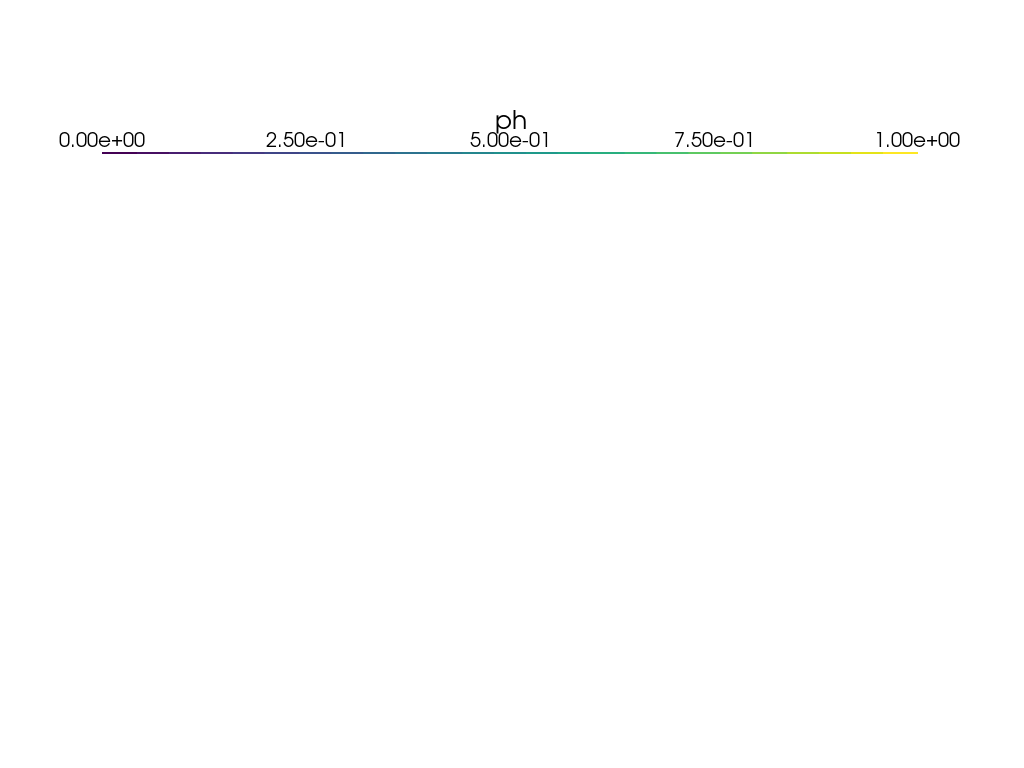

In [ ]:
plotter.show()

In [18]:
import numpy as np
from PIL import Image

#imgs = np.random.randint(0, 255, (100, 50, 50, 3), dtype=np.uint8)
imgs = [Image.fromarray((pp.reshape(11,11,-1)[:,:,1]*100).astype(np.uint8)) for pp in Vv]
# duration is the number of milliseconds between frames; this is 40 frames per second
imgs[0].save("array.gif", format="GIF", save_all=True, append_images=imgs[1:], duration=100, loop=0)

static


error: XDG_RUNTIME_DIR is invalid or not set in the environment.


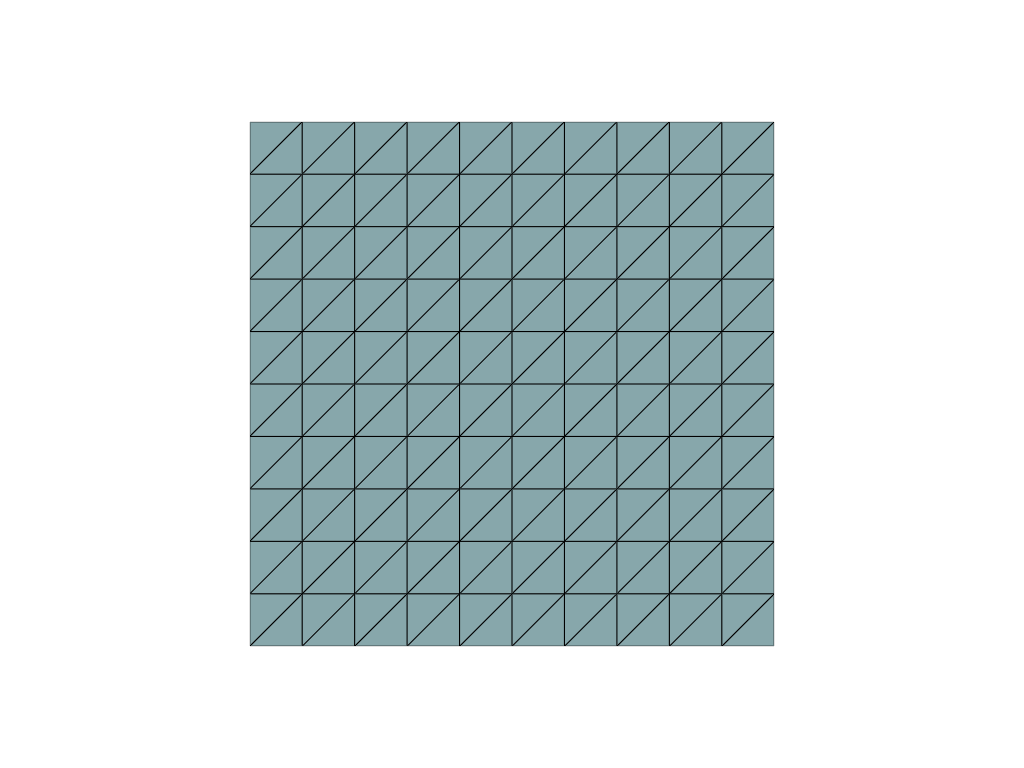

error: XDG_RUNTIME_DIR is invalid or not set in the environment.


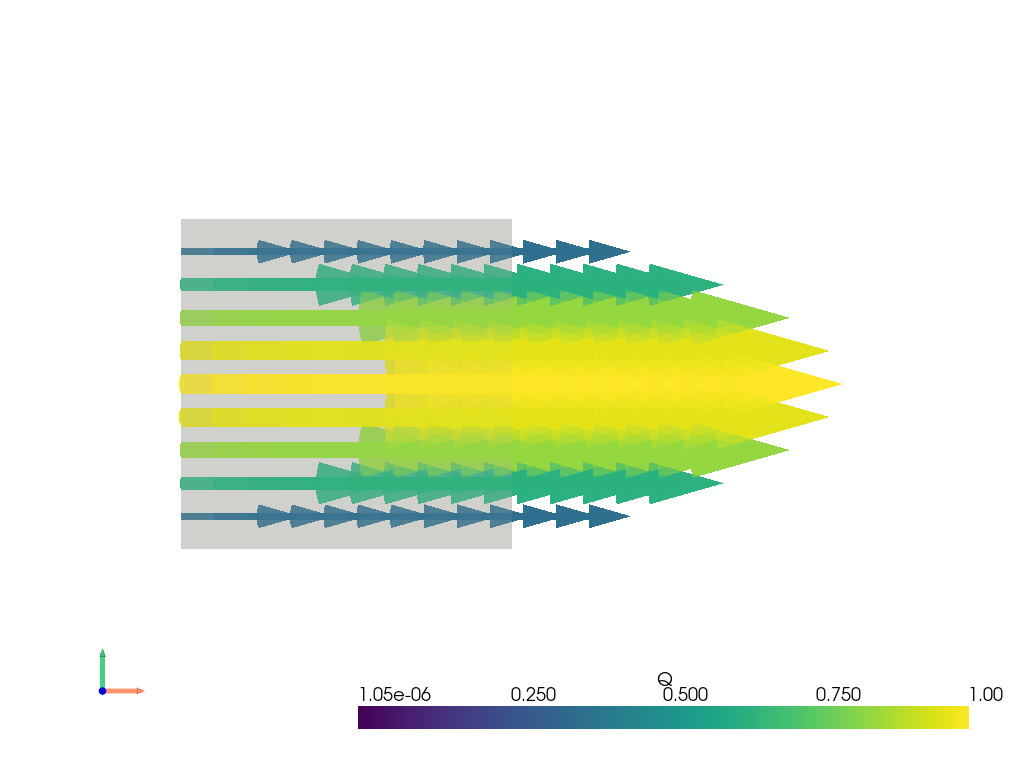

In [32]:
from dolfinx import plot
import pyvista
print(pyvista.global_theme.jupyter_backend)
domain=domain
pyvista.start_xvfb()
tdim = domain.topology.dim
fdim = tdim - 1
domain.topology.create_connectivity(tdim, tdim)
topology, cell_types, geometry = plot.vtk_mesh(domain, tdim)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)

plotter = pyvista.Plotter()
plotter.add_mesh(grid, show_edges=True)
plotter.view_xy()
if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    figure = plotter.screenshot("fundamentals_mesh.png")

u_grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)
#P_=np.concatenate((P,np.ones((P.shape[0],1))),axis=1)
#u_grid["P"] = P_
#P=((P-P.min(axis=0))/(P.max(axis=0)-P.min(axis=0)))*0.5
P=Vv[-1]
P_=np.concatenate((P,np.zeros((P.shape[0],1))),axis=1)
u_grid["P"]=P_
u_grid.set_active_vectors("P")

p = pyvista.Plotter()
p.add_mesh(u_grid.arrows, line_width=0.5,lighting=False,opacity=0.9, scalar_bar_args={"title": "Q"})
p.add_mesh(u_grid, color="grey", ambient=0.6, opacity=0.6, show_edges=False)
_ = p.add_axes(line_width=5, labels_off=True)
p.view_xy()

p.show()

static


error: XDG_RUNTIME_DIR is invalid or not set in the environment.


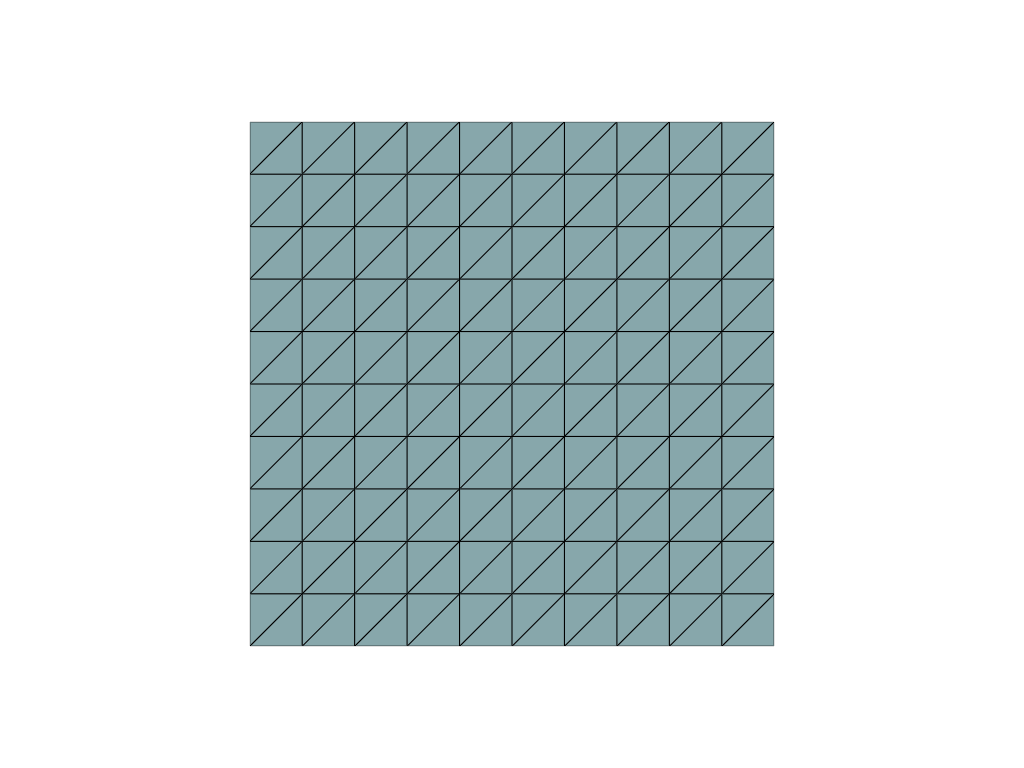

error: XDG_RUNTIME_DIR is invalid or not set in the environment.


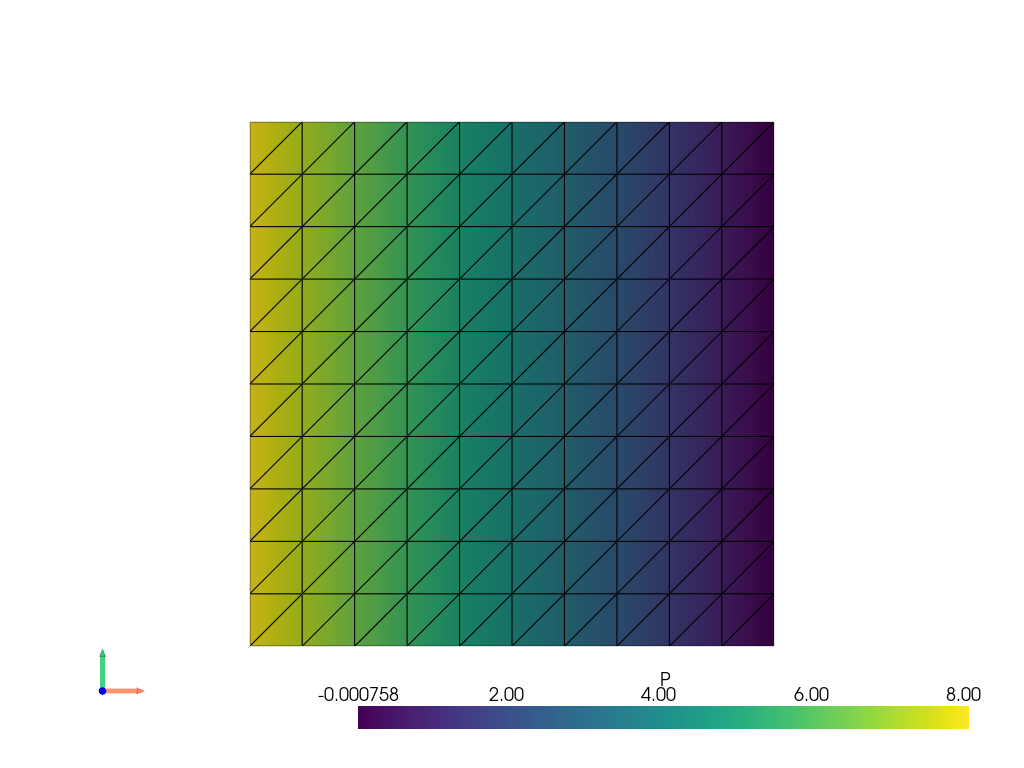

In [38]:
from dolfinx import plot
import pyvista
print(pyvista.global_theme.jupyter_backend)
domain=domain
pyvista.start_xvfb()
tdim = domain.topology.dim
fdim = tdim - 1
domain.topology.create_connectivity(tdim, tdim)
topology, cell_types, geometry = plot.vtk_mesh(domain, tdim)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)

plotter = pyvista.Plotter()
plotter.add_mesh(grid, show_edges=True)
plotter.view_xy()
if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    figure = plotter.screenshot("fundamentals_mesh.png")

u_grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)
#P_=np.concatenate((P,np.ones((P.shape[0],1))),axis=1)
#u_grid["P"] = P_
#P=((P-P.min(axis=0))/(P.max(axis=0)-P.min(axis=0)))*0.5
#P=Pv[-1]
#P_=np.concatenate((P,np.zeros((P.shape[0],1))),axis=1)
u_grid.point_data["P"]=Pv[2]
u_grid.set_active_scalars("P")
u_plotter = pyvista.Plotter()
u_plotter.add_mesh(u_grid, show_edges=True)
u_plotter.view_xy()
u_plotter.add_axes(line_width=5, labels_off=True)
if not pyvista.OFF_SCREEN:
    u_plotter.show()

In [32]:
#Vv[0].x.array.shape
Vv[0].evaluate?

Signature: Vv[0].evaluate(x, mapping, component, index_values, derivatives=())
Docstring: Get *self* from *mapping* and return the component asked for.
File:      /dolfinx-env/lib/python3.12/site-packages/ufl/core/terminal.py
Type:      method

# Data read

In [3]:
! pwd

/app


In [1]:
import os
ROOT="/app"
os.listdir(os.path.join(ROOT,"Exploring_repo","Data"))

['2D_NS_eq_Dirichlet_Linear_Linear_f_zero_10x10.csv',
 '2D_NS_eq_Dirichlet_Linear_Linear_f_zero_S10x10_T10_500.csv',
 '2D_poisson_eq_Dirichlet_BC_64x64.csv',
 '2D_poisson_eq_Dirichlet_Const_f_Const_64x64.csv',
 '2D_poisson_eq_Dirichlet_Const_Linear_f_Const_64x64.csv',
 '2D_poisson_eq_Dirichlet_Const_Quad_f_Const_64x64.csv',
 '2D_poisson_eq_Dirichlet_Exp_Exp_f_Const_64x64.csv',
 '2D_poisson_eq_Dirichlet_Exp_Exp_f_Linear_Linear_64x64.csv',
 '2D_poisson_eq_Dirichlet_Linear_Linear_f_Const_64x64.csv',
 '2D_poisson_eq_Dirichlet_Quad_Quad_f_Const_64x64.csv',
 '2D_poisson_eq_D_N_R_quad_f_Linear_Linear_64x64.csv',
 '32x32_2D_poisson_eq_Dirichlet_BC.csv',
 '32x32_2D_poisson_eq_Dirichlet_BC2.csv',
 '3D_poisson_eq_Dirichlet_BC_64x64x64.csv',
 '3D_poisson_eq_Dirichlet_Const_Linear_f_Const_64x64x64.csv',
 '64x64_2D_poisson_eq_Dirichlet_BC.csv',
 '64x64_2D_poisson_eq_Dirichlet_BC2.csv',
 '64x64_2D_poisson_eq_Dirichlet_BC3.csv',
 '64x64_2D_poisson_eq_Dirichlet_BC4.csv',
 '64x64_2D_poisson_eq_Dirichlet

In [13]:
import pandas as pd
import numpy as np

import h5py
filename = os.path.join(ROOT,"Exploring_repo","Data","PERMI_0_all.h5")

with h5py.File(filename, "r") as f:
    # Print all root level object names (aka keys) 
    # these can be group or dataset names 
    print("Keys: %s" % f.keys())
    # get first object name/key; may or may NOT be a group
    a_group_key = list(f.keys())[0]

    # get the object type for a_group_key: usually group or dataset
    print(type(f[a_group_key]))
    d1=pd.DataFrame(f[a_group_key])

    # If a_group_key is a group name, 
    # this gets the object names in the group and returns as a list
    data = list(f[a_group_key])

    # If a_group_key is a dataset name, 
    # this gets the dataset values and returns as a list
    data = list(f[a_group_key])
    # preferred methods to get dataset values:
    ds_obj = f[a_group_key]      # returns as a h5py dataset object
    #ds_arr = f[a_group_key][()]  # returns as a numpy array

Keys: <KeysViewHDF5 ['BHP', 'Restrictions', 'features', 'outout']>
<class 'h5py._debian_h5py_serial._hl.group.Group'>


In [3]:
f = h5py.File(filename)

In [18]:
for key in f.keys():
    print(key) #Names of the root level object names in HDF5 file - can be groups or datasets.
    print(type(f[key]))

BHP
<class 'h5py._debian_h5py_serial._hl.group.Group'>
Restrictions
<class 'h5py._debian_h5py_serial._hl.group.Group'>
features
<class 'h5py._debian_h5py_serial._hl.group.Group'>
outout
<class 'h5py._debian_h5py_serial._hl.group.Group'>


In [19]:
f = h5py.File(filename)

for key in f.keys():
    print(key) #Names of the root level object names in HDF5 file - can be groups or datasets.
    print(type(f[key]))

group = f["features"]
#group = f["BHP"]

#Checkout what keys are inside that group.
for key in group.keys():
    print(key)

# This assumes group[some_key_inside_the_group] is a dataset, 
# and returns a np.array:
item = group["block0_items"][()]
data = group["block0_values"][()]
#Do whatever you want with data

#After you are done
#f.close()
print(item.shape)
print(data.shape)

BHP
<class 'h5py._debian_h5py_serial._hl.group.Group'>
Restrictions
<class 'h5py._debian_h5py_serial._hl.group.Group'>
features
<class 'h5py._debian_h5py_serial._hl.group.Group'>
outout
<class 'h5py._debian_h5py_serial._hl.group.Group'>
axis0
axis1
block0_items
block0_values
(1698,)
(6618, 1698)


In [22]:
get_prop = lambda com_prop: com_prop.split("_")[0]
cols_list=list(map(lambda c: c.decode("utf-8"),item.tolist()))
props=np.unique(np.array(list(map(get_prop,cols_list[18:]))))
t=1
print(list(map(lambda p: p+"_"+str(t),props)))

features_data=pd.DataFrame(
    data=data,
    columns=cols_list
    )

SVP=np.stack(list(map(lambda t: features_data[list(map(lambda p: p+"_"+str(t),props))].values,np.arange(1,241))),axis=2)
print(SVP.shape)

['OS_1', 'OV_1', 'OVF_1', 'P_1', 'SGR_1', 'WS_1', 'WV_1']
(6618, 7, 240)


In [45]:
XYKIJ=features_data[["X","Y","Z","PermeabilityI","PermeabilityJ","PermeabilityK"]].values

In [23]:
list(features_data.columns)

['well',
 'type',
 'completation',
 'X',
 'Y',
 'Z',
 'FR',
 'Porosity',
 'PermeabilityK',
 'NetPay',
 'PermeabilityJ',
 'GridCentroidY',
 'GridTop',
 'GridThickness',
 'GrossBlockVolume',
 'GridCentroidX',
 'PermeabilityI',
 'NettoGrossRatio',
 'P_1',
 'OS_1',
 'OVF_1',
 'SGR_1',
 'WS_1',
 'OV_1',
 'WV_1',
 'P_2',
 'OS_2',
 'OVF_2',
 'SGR_2',
 'WS_2',
 'OV_2',
 'WV_2',
 'P_3',
 'OS_3',
 'OVF_3',
 'SGR_3',
 'WS_3',
 'OV_3',
 'WV_3',
 'P_4',
 'OS_4',
 'OVF_4',
 'SGR_4',
 'WS_4',
 'OV_4',
 'WV_4',
 'P_5',
 'OS_5',
 'OVF_5',
 'SGR_5',
 'WS_5',
 'OV_5',
 'WV_5',
 'P_6',
 'OS_6',
 'OVF_6',
 'SGR_6',
 'WS_6',
 'OV_6',
 'WV_6',
 'P_7',
 'OS_7',
 'OVF_7',
 'SGR_7',
 'WS_7',
 'OV_7',
 'WV_7',
 'P_8',
 'OS_8',
 'OVF_8',
 'SGR_8',
 'WS_8',
 'OV_8',
 'WV_8',
 'P_9',
 'OS_9',
 'OVF_9',
 'SGR_9',
 'WS_9',
 'OV_9',
 'WV_9',
 'P_10',
 'OS_10',
 'OVF_10',
 'SGR_10',
 'WS_10',
 'OV_10',
 'WV_10',
 'P_11',
 'OS_11',
 'OVF_11',
 'SGR_11',
 'WS_11',
 'OV_11',
 'WV_11',
 'P_12',
 'OS_12',
 'OVF_12',
 'SGR_1

In [34]:
# OV oil viscocity
print(np.unique(SVP[:,1,:]))
# WV oil viscocity
print(np.unique(SVP[:,-1,:]))
# WV oil viscocity
print(np.unique(SVP[:,4,:]))

print(np.unique(features_data.FR.values))
print(np.unique(features_data.Porosity.values))


[1.295]
[0.32]
[1.]
[0.]
[0.2]


array([0.2])

In [25]:
print(np.unique(features_data.X.values))
print(np.unique(features_data.GridCentroidX.values))
print(np.unique(features_data.Y.values))
print(np.unique(features_data.GridCentroidY.values))
print(np.unique(features_data.OS_200.values))

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36.
 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53. 54.
 55. 56. 57. 58. 59. 60.]
[  50.  150.  250.  350.  450.  550.  650.  750.  850.  950. 1050. 1150.
 1250. 1350. 1450. 1550. 1650. 1750. 1850. 1950. 2050. 2150. 2250. 2350.
 2450. 2550. 2650. 2750. 2850. 2950. 3050. 3150. 3250. 3350. 3450. 3550.
 3650. 3750. 3850. 3950. 4050. 4150. 4250. 4350. 4450. 4550. 4650. 4750.
 4850. 4950. 5050. 5150. 5250. 5350. 5450. 5550. 5650. 5750. 5850. 5950.]
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36.
 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53. 54.
 55. 56. 57. 58. 59. 60.]
[-5950. -5850. -5750. -5650. -5550. -5450. -5350. -5250. -5150. -5050.
 -4950. -4850. -4750. -4650. -4550. -4450. -4350. -4250. -4150. -4050.
 -

In [173]:
!pip install einops

In [64]:
import pandas as pd
import os
from einops import repeat,rearrange
#['OS_1', 'OV_1', 'OVF_1', 'P_1', 'SGR_1', 'WS_1', 'WV_1']
def solution_data_normalization(Uv,X):
#    Uv_=np.concatenate([Vv_,Pv_],axis=-1)
    X=repeat(X[:,:],"p v -> t p v",t=240)
    T=repeat(np.array([t for t in range(1,241)]),"t -> t p 1",p=X.shape[1])
    XT=np.concatenate([X,T],axis=-1)
    Uv=rearrange(Uv,"p v t-> (t p) v")
    XT=rearrange(XT,"t p v -> (t p) v")

    data_dict={
        "Os":Uv[:,0].tolist(),
        "Bo":Uv[:,2].tolist(),
        "P":Uv[:,2].tolist(),
        "x":XT[:,0].tolist(),
        "y":XT[:,1].tolist(),
        "z":XT[:,2].tolist(),
        "Ki":XT[:,3].tolist(),
        "Kj":XT[:,4].tolist(),
        "Kk":XT[:,5].tolist(),
        "t":XT[:,6].tolist()
    }
    return pd.DataFrame(data_dict)


In [66]:
data=solution_data_normalization(SVP,XYKIJ)
data

,u,v,p,x,y,z,Ki,Kj,Kk,t
0,0.700000,1.295,0.967360,2.0,2.0,1.0,100.0,100.0,100.0,1.0
1,0.700000,1.295,0.967360,1.0,1.0,1.0,100.0,100.0,100.0,1.0
2,0.700000,1.295,0.967360,2.0,1.0,1.0,100.0,100.0,100.0,1.0
3,0.700000,1.295,0.967360,3.0,1.0,1.0,100.0,100.0,100.0,1.0
4,0.700000,1.295,0.967360,4.0,1.0,1.0,100.0,100.0,100.0,1.0
...,...,...,...,...,...,...,...,...,...,...
1588315,0.437890,1.295,0.961605,56.0,50.0,1.0,1000.0,1000.0,1000.0,240.0
1588316,0.448114,1.295,0.961606,57.0,50.0,1.0,1000.0,1000.0,1000.0,240.0
1588317,0.457673,1.295,0.961586,58.0,50.0,1.0,1000.0,1000.0,1000.0,240.0
1588318,0.476657,1.295,0.961589,59.0,50.0,1.0,1000.0,1000.0,1000.0,240.0


In [68]:
data.to_csv(os.path.join(ROOT,"Exploring_repo","Data","60x60_T240_2D_2P_Darcy_flow.csv"))

In [145]:
import numpy as np
cols=list(features_data.columns)
get_prop = lambda com_prop: com_prop.decode("utf-8").split("_")[0]
#(list(features_data.columns))[-1].decode("utf-8").split("_")[0]

#(list(features_data.columns))[-1].decode("utf-8").split("_")[0]
np.unique(np.array(list(map(get_prop,cols[18:]))))

array(['OS', 'OV', 'OVF', 'P', 'SGR', 'WS', 'WV'], dtype='<U3')

In [142]:
cols[18:20]

[b'P_1', b'OS_1']

In [121]:
item.tolist()[18:]

[b'P_1',
 b'OS_1',
 b'OVF_1',
 b'SGR_1',
 b'WS_1',
 b'OV_1',
 b'WV_1',
 b'P_2',
 b'OS_2',
 b'OVF_2',
 b'SGR_2',
 b'WS_2',
 b'OV_2',
 b'WV_2',
 b'P_3',
 b'OS_3',
 b'OVF_3',
 b'SGR_3',
 b'WS_3',
 b'OV_3',
 b'WV_3',
 b'P_4',
 b'OS_4',
 b'OVF_4',
 b'SGR_4',
 b'WS_4',
 b'OV_4',
 b'WV_4',
 b'P_5',
 b'OS_5',
 b'OVF_5',
 b'SGR_5',
 b'WS_5',
 b'OV_5',
 b'WV_5',
 b'P_6',
 b'OS_6',
 b'OVF_6',
 b'SGR_6',
 b'WS_6',
 b'OV_6',
 b'WV_6',
 b'P_7',
 b'OS_7',
 b'OVF_7',
 b'SGR_7',
 b'WS_7',
 b'OV_7',
 b'WV_7',
 b'P_8',
 b'OS_8',
 b'OVF_8',
 b'SGR_8',
 b'WS_8',
 b'OV_8',
 b'WV_8',
 b'P_9',
 b'OS_9',
 b'OVF_9',
 b'SGR_9',
 b'WS_9',
 b'OV_9',
 b'WV_9',
 b'P_10',
 b'OS_10',
 b'OVF_10',
 b'SGR_10',
 b'WS_10',
 b'OV_10',
 b'WV_10',
 b'P_11',
 b'OS_11',
 b'OVF_11',
 b'SGR_11',
 b'WS_11',
 b'OV_11',
 b'WV_11',
 b'P_12',
 b'OS_12',
 b'OVF_12',
 b'SGR_12',
 b'WS_12',
 b'OV_12',
 b'WV_12',
 b'P_13',
 b'OS_13',
 b'OVF_13',
 b'SGR_13',
 b'WS_13',
 b'OV_13',
 b'WV_13',
 b'P_14',
 b'OS_14',
 b'OVF_14',
 b'SGR_14',
 b'W